In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pickle
import os
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from importlib import reload
import itertools
from collections import defaultdict
from tqdm import tqdm

import sys
sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/t-recs')
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users
import trecs.matrix_ops as mo

sys.path.insert(1, '../')
from wrapper.models.bubble import BubbleBurster
from src.utils import load_and_process_movielens, compute_embeddings, compute_constrained_clusters, user_topic_mapping, create_cluster_user_pairs
from metrics.clustering_metrics import MeanCosineSim, MeanDistanceFromCentroid, MeanCosineSimPerCluster, MeanDistanceFromCentroidPerCluster

random_state = np.random.seed(42)

In [2]:
params = {
    "max_iter":1000,
    "num_clusters":10,
    "num_attrs":20,
    "drift":0.1,
    "attention_exp":-0.8,
    "startup_iters":5,
    "sim_iters":25,
    "repeated_training":True
}

binary_ratings_matrix = load_and_process_movielens(file_path='/Users/madisonthantu/Desktop/DREAM/data/ml-100k/u.data')
# Get user and item representations using NMF
user_representation, item_representation = compute_embeddings(binary_ratings_matrix, n_attrs=params["num_attrs"], max_iter=params["max_iter"])
# Define topic clusters using K-Means
item_cluster_ids, item_cluster_centers = compute_constrained_clusters(item_representation.T, name='item', n_clusters=params["num_clusters"])
user_cluster_ids, user_cluster_centers = compute_constrained_clusters(user_representation, name='user', n_clusters=params["num_clusters"])
# Get user pairs - global user pairs, intra-cluster user pairs, inter-cluster user pairs
global_user_pairs = []
num_users = len(user_cluster_ids)
for u_idx in range(num_users):
    global_user_pairs += [(u_idx, v_idx) for v_idx in range(u_idx+1, num_users)]
inter_cluster_user_pairs, intra_cluster_user_pairs = create_cluster_user_pairs(user_cluster_ids)

users = Users(
    actual_user_profiles=user_representation, 
    repeat_interactions=False,
    drift=params["drift"],
    attention_exp=params["attention_exp"]
)

# measurements = [
#     MSEMeasurement(),  
#     InteractionSpread(),                
#     InteractionSimilarity(pairs=global_user_pairs, name='global_interaction_similarity'), 
#     InteractionSimilarity(pairs=inter_cluster_user_pairs, name='inter_cluster_interaction_similarity'), 
#     InteractionSimilarity(pairs=intra_cluster_user_pairs, name='intra_cluster_interaction_similarity'), 
# ]

bubble = BubbleBurster(
    actual_user_representation=users, 
    
    actual_item_representation=item_representation,
    item_topics=item_cluster_ids,
    num_attributes=params["num_attrs"],
    num_items_per_iter=10,
    # seed=rng,
    record_base_state=True
)

# bubble.add_metrics(*measurements)

Calculating embeddings...
Calculated embeddings.
Calculating constrained clusters...
Calculated constrained clusters.
Calculating constrained clusters...
Calculated constrained clusters.


### **Metric:** Average cosine sim

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
from math import comb
from itertools import combinations

class AvgCosineSim():
    def __init__(self, pairs, name="avg_cosine_sim", verbose=False):
        self.pairs = pairs
        self.first_user = [p[0] for p in pairs]
        self.second_user = [p[1] for p in pairs]

    def measure(self, recommender):
        cos_sim_matrix = cosine_similarity(recommender.users.actual_user_profiles.value)
        inter_clust_cos_sim = cos_sim_matrix[self.first_user, self.second_user]
        return np.mean(inter_clust_cos_sim)


In [4]:
avg_intra_cluster_cosine_sim = AvgCosineSim(intra_cluster_user_pairs, params["num_clusters"])
avg_intra_cluster_cosine_sim.measure(bubble)
# print(avg_intra_cluster_cosine_sim.measure(bubble))

0.3180862506255128

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
from math import comb
from itertools import combinations

class AvgCosineSimPerCluster():
    def __init__(self, user_cluster_ids, n_clusts, name="cosine_sim_per_cluster", verbose=False):
        self.user_cluster_ids = user_cluster_ids
        self.n_clusts = n_clusts
        assert (np.unique(user_cluster_ids).shape[0] == n_clusts), "User cluster assignment does not match number of clusters"

    def measure(self, recommender):
        avg_cos_sim_per_clust = list()
        
        for clust in range(self.n_clusts):
            clust_users = np.where(self.user_cluster_ids == clust)[0]
            user_embeddings = recommender.users.actual_user_profiles.value[clust_users, :]
            cos_sim_matrix = cosine_similarity(user_embeddings)
            cos_sim_idxs = np.triu_indices(cos_sim_matrix.shape[0], k=1)
            cos_sim_vals = cos_sim_matrix[cos_sim_idxs[0], cos_sim_idxs[1]]
            avg_cos_sim_per_clust.append(np.mean(cos_sim_vals))
            
        return avg_cos_sim_per_clust

In [28]:
avg_intra_cluster_cosine_sim = AvgCosineSimPerCluster(user_cluster_ids, params["num_clusters"])
res = avg_intra_cluster_cosine_sim.measure(bubble)
print(res)

[0.7761464402401791, 0.7616792154447272, 0.7846735751028342, 0.821939487668927, 0.7878008557434871, 0.7785059435264979, 0.7633132563807994, 0.7931131931385692, 0.8071428192991922, 0.7956167357351537]


### **Metric:** Average distance from centroid

In [17]:
class MeanDistanceFromCentroid():
    def __init__(self, user_cluster_ids, user_centroids, name="avg_distance_from_centroid", verbose=False):
        self.cluster_ids = user_cluster_ids
        self.user_centroids = user_centroids
        
    def measure(self, recommender):
        centroid_vecs = self.user_centroids[self.cluster_ids]
        # dist = np.linalg.norm(recommender.users.actual_user_profiles.value - centroid_vecs, axis=1)
        dist = np.linalg.norm(recommender.users.actual_user_profiles.value - centroid_vecs, axis=1)
        print(dist.shape)
        return np.mean(dist)
    
    
class test():
    def __init__(self, user_cluster_ids, user_centroids, name="avg_distance_from_centroid", verbose=False):
        self.user_ids = np.arange(user_cluster_ids.shape[0])
        self.cluster_ids = user_cluster_ids
        self.user_centroids = user_centroids
        
    def measure(self, recommender):
        cum_norm = 0
        for i in range(self.user_ids.shape[0]):
            user_rep = recommender.users.actual_user_profiles.value[i]
            centroid = self.user_centroids[self.cluster_ids[i]]
            cum_norm += np.linalg.norm(user_rep - centroid)
        return cum_norm / self.user_ids.shape[0]

In [18]:
global_user_cluster_ids, global_user_cluster_centers = compute_constrained_clusters(user_representation, name='user', n_clusters=1)

Calculating constrained clusters...
Calculated constrained clusters.


In [19]:
centroid_dist = MeanDistanceFromCentroid(user_cluster_ids, user_cluster_centers)
res = centroid_dist.measure(bubble)
print(res.shape)
print(res)

centroid_dist = MeanDistanceFromCentroid(global_user_cluster_ids, global_user_cluster_centers)
res = centroid_dist.measure(bubble)
print(res.shape)
print(res)

(943,)
()
0.6378626912939308
(943,)
()
0.6479853518718514


In [55]:
test_centroid_dist = test(user_cluster_ids, user_cluster_centers)
test_res = test_centroid_dist.measure(bubble)
print(test_res.shape)
print(test_res)

test_centroid_dist = test(global_user_cluster_ids, global_user_cluster_centers)
test_res = test_centroid_dist.measure(bubble)
print(test_res.shape)
print(test_res)
# print(avg_intra_cluster_cosine_sim.measure(bubble))

()
0.6378626912939308
()
0.6479853518718517


In [56]:
class MeanDistanceFromCentroidPerCluster():
    def __init__(self, user_cluster_ids, user_centroids, n_clusts, name="mean_distance_from_centroid_per_cluster", verbose=False):
        self.user_cluster_ids = user_cluster_ids
        self.cluster_ids = user_cluster_ids
        self.user_centroids = user_centroids
        self.n_clusts = n_clusts
        
    def measure(self, recommender):
        avg_dist_per_clust = list()
        for clust in range(self.n_clusts):
            clust_users = np.where(self.user_cluster_ids == clust)[0]
            user_embeddings = recommender.users.actual_user_profiles.value[clust_users, :]
            dist = np.linalg.norm(np.subtract(user_embeddings, self.user_centroids[clust]), axis=1)
            avg_dist_per_clust.append(np.mean(dist))
        return avg_dist_per_clust
    
    
class Test2():
    def __init__(self, user_cluster_ids, user_centroids, n_clusts, name="mean_distance_from_centroid_per_cluster", verbose=False):
        self.user_cluster_ids = user_cluster_ids
        self.cluster_ids = user_cluster_ids
        self.user_centroids = user_centroids
        self.n_clusts = n_clusts
        # print(self.user_centroids.shape)
        
    def measure(self, recommender):
        avg_dist_per_clust = list()
        cum_dist = np.array([])
        
        for clust in range(self.n_clusts):
            clust_users = np.where(self.user_cluster_ids == clust)[0]
            user_embeddings = recommender.users.actual_user_profiles.value[clust_users, :]
            # print(user_embeddings.shape)
            dist = np.linalg.norm(np.subtract(user_embeddings, self.user_centroids[clust]), axis=1)
            # print(dist.shape)
            avg_dist_per_clust.append(np.mean(dist))
            cum_dist = np.concatenate((cum_dist, dist))
            
        print(np.mean(cum_dist))
        
        return avg_dist_per_clust    

In [59]:
centroid_dist = MeanDistanceFromCentroidPerCluster(user_cluster_ids, user_cluster_centers, params["num_clusters"])
res = centroid_dist.measure(bubble)
print(res)
print(sum(res) / len(res))
print()

centroid_dist = Test2(user_cluster_ids, user_cluster_centers, params["num_clusters"])
res = centroid_dist.measure(bubble)
print(res)
print(sum(res) / len(res))

[0.5466654788538269, 3.018735828429659, 1.2347611442208075, 4.94051521589432, 1.2375065461127304, 1.3689782580318501, 0.25131660508056874, 2.41896241589392, 3.7634275161149344, 1.3293774937647111]
2.0110246502397326

0.6378626912939309
[0.5466654788538269, 3.018735828429659, 1.2347611442208075, 4.94051521589432, 1.2375065461127304, 1.3689782580318501, 0.25131660508056874, 2.41896241589392, 3.7634275161149344, 1.3293774937647111]
2.0110246502397326


In [60]:
centroid_dist = MeanDistanceFromCentroidPerCluster(global_user_cluster_ids, global_user_cluster_centers, 1)
res = centroid_dist.measure(bubble)
print(res)
print()

centroid_dist = Test2(global_user_cluster_ids, global_user_cluster_centers, 1)
res = centroid_dist.measure(bubble)
print(res)

[0.6479853518718514]

0.6479853518718514
[0.6479853518718514]


# **Running simulation** with new clustering metrics

In [3]:
measurements = [
    MSEMeasurement(),  
    InteractionSpread(),                
    InteractionSimilarity(pairs=global_user_pairs, name='global_interaction_similarity'), 
    InteractionSimilarity(pairs=inter_cluster_user_pairs, name='inter_cluster_interaction_similarity'), 
    InteractionSimilarity(pairs=intra_cluster_user_pairs, name='intra_cluster_interaction_similarity'), 
    
    MeanCosineSim(pairs=intra_cluster_user_pairs, name='intra_cluster_cosine_sim'),
    MeanCosineSim(pairs=inter_cluster_user_pairs, name='inter_cluster_cosine_sim'),
    MeanDistanceFromCentroid(user_cluster_ids, user_cluster_centers, name="mean_distance_from_centroid"), 
    MeanCosineSimPerCluster(user_cluster_ids, params["num_clusters"], name="mean_cosine_sim_per_cluster"), 
    MeanDistanceFromCentroidPerCluster(user_cluster_ids, user_cluster_centers, params["num_clusters"], name="mean_distance_from_centroid_per_cluster")
]

bubble.add_metrics(*measurements)

In [4]:
bubble.startup_and_train(timesteps=params["startup_iters"])
bubble.run(timesteps=params["sim_iters"], train_between_steps=params["repeated_training"])
bubble.close() # end logging

100%|██████████| 25/25 [01:55<00:00,  4.61s/it]


In [6]:
measurements = bubble.get_measurements()
df_measurements = pd.DataFrame(measurements)

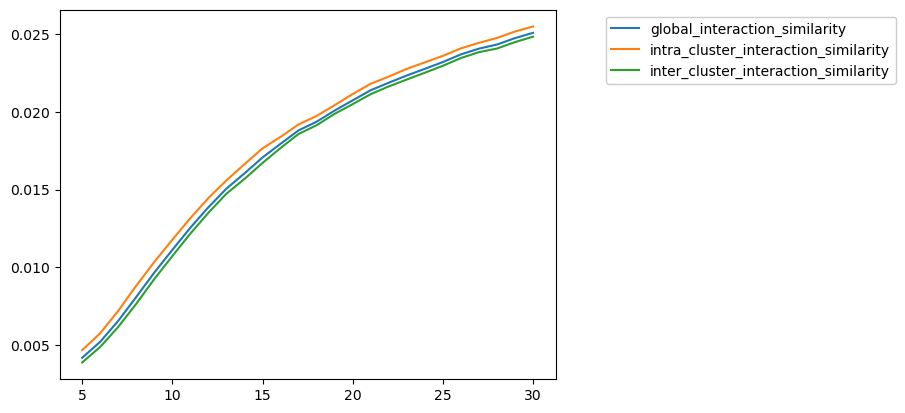

In [8]:
plt.plot(df_measurements["global_interaction_similarity"][params["startup_iters"]:], label="global_interaction_similarity")
plt.plot(df_measurements["intra_cluster_interaction_similarity"][params["startup_iters"]:], label="intra_cluster_interaction_similarity")
plt.plot(df_measurements["inter_cluster_interaction_similarity"][params["startup_iters"]:], label="inter_cluster_interaction_similarity")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))

.

# Implementing reclustering

In [3]:
bubble.startup_and_train(timesteps=params["startup_iters"])
bubble.run(timesteps=params["sim_iters"], train_between_steps=params["repeated_training"])
bubble.close() # end logging

100%|██████████| 25/25 [01:55<00:00,  4.60s/it]


In [21]:
measurements = bubble.get_measurements()
df_measurements = pd.DataFrame(measurements)

In [22]:
df_measurements.head()

,mse,interaction_spread,global_interaction_similarity,inter_cluster_interaction_similarity,intra_cluster_interaction_similarity,timesteps
0,0.090065,NaN,NaN,NaN,NaN,0
1,0.098064,-940.0,0.001288,0.001173,0.001477,1
2,0.105862,0.5,0.001821,0.001712,0.002001,2
3,0.113667,0.0,0.002664,0.002485,0.002959,3
4,0.121501,0.0,0.003450,0.003196,0.003868,4


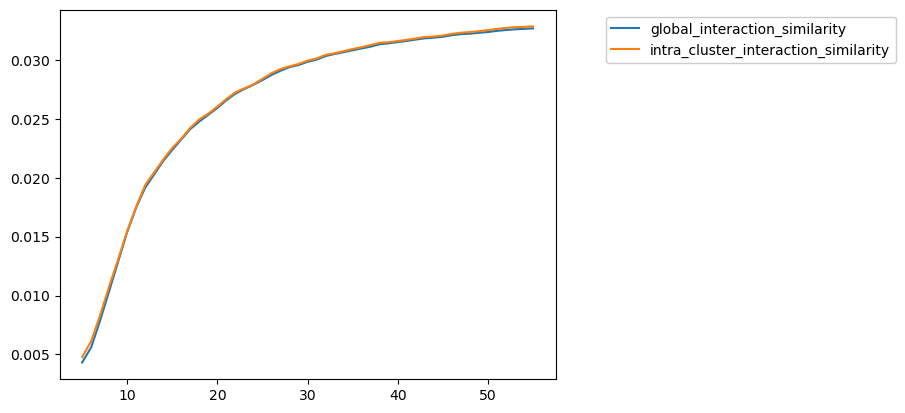

In [23]:
plt.plot(df_measurements["global_interaction_similarity"][params["startup_iters"]:], label="global_interaction_similarity")
plt.plot(df_measurements["intra_cluster_interaction_similarity"][params["startup_iters"]:], label="intra_cluster_interaction_similarity")
# plt.plot(df_measurements["inter_cluster_interaction_similarity"][params["startup_iters"]:], label="inter_cluster_interaction_similarity")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))

In [24]:
for metric in bubble.metrics:
    if metric.name == "inter_cluster_interaction_similarity":
        metric.pairs = global_user_pairs

In [25]:
bubble.run(timesteps=params["sim_iters"], train_between_steps=params["repeated_training"])
bubble.close() # end logging

100%|██████████| 25/25 [04:37<00:00, 11.10s/it]


In [26]:
measurements = bubble.get_measurements()
df_measurements = pd.DataFrame(measurements)

In [27]:
for metric in bubble.metrics:
    if metric.name == "inter_cluster_interaction_similarity":
        pairs_inter_cluster = metric.pairs
    if metric.name == "global_interaction_similarity":
        pairs_global = metric.pairs
        
print(pairs_inter_cluster == pairs_global)

True


In [29]:
df_measurements.tail()

,mse,interaction_spread,global_interaction_similarity,inter_cluster_interaction_similarity,intra_cluster_interaction_similarity,timesteps
76,1.213925,-7.0,0.033181,0.033181,0.033336,76
77,1.214285,8.5,0.033190,0.033190,0.033352,77
78,1.214077,-8.0,0.033203,0.033203,0.033355,78
79,1.213693,5.5,0.033225,0.033225,0.033385,79
80,1.214157,-2.0,0.033228,0.033228,0.033377,80
